In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import LabelEncoder

In [4]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
##

In [5]:
import sqlalchemy 
import pandas

In [6]:
#### DB Connection configuration
username = "postgres"
password = "usaccident"
endpoint = "us-accident.cnnhjjyro1tm.us-east-1.rds.amazonaws.com"  # something like amazonaws.com:5432
dbname   = "US_Accident"

In [7]:
## Connect to Db
con = sqlalchemy.create_engine("postgresql://%s:%s@%s/%s" % (username, password, endpoint, dbname))

In [8]:
## Get Data
accident_df = pandas.read_sql("select * from clean_accident_data;", con)
#print(accident_df)

## How Severity the Accidents is ?

In [9]:
# Files to laod
#accident_data= "DataFile/mock_accident_data.csv"
#accident_data= "DataFile/US_Accidents_Dec21_updated.csv"
#accident_data="https://umausdata.s3.amazonaws.com/DataFile/mock_accident_data.csv"
#accident_df=pd.read_csv(accident_data)

In [10]:
accident_df.head()

,index,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Street,Side,...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Year,Month,Day,Hour,Weekday,time_duration
0,0,1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,3.230,Outerbelt E,R,...,False,False,False,Night,2016,Feb,8,0,Mon,360.0
1,1,5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,0.500,I-75 S,R,...,False,False,False,Day,2016,Feb,8,7,Mon,360.0
2,2,8,2,2016-02-08 11:51:46,2016-02-08 17:51:46,41.375310,-81.820170,0.521,I-71 S,R,...,False,False,False,Day,2016,Feb,8,11,Mon,360.0
3,3,10,2,2016-02-08 15:16:43,2016-02-08 21:16:43,40.109310,-82.968490,0.826,Outerbelt W,R,...,False,False,False,Day,2016,Feb,8,15,Mon,360.0
4,4,11,2,2016-02-08 15:43:50,2016-02-08 21:43:50,39.192880,-84.477230,0.307,I-75 N,R,...,False,False,False,Day,2016,Feb,8,15,Mon,360.0


In [11]:
print(accident_df.columns)

Index(['index', 'ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Street', 'Side', 'City', 'County',
       'State', 'Zipcode', 'Timezone', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Year', 'Month', 'Day', 'Hour',
       'Weekday', 'time_duration'],
      dtype='object')


In [12]:
#drop the non-beneficial columns
#accident_df=accident_df.drop(columns=['ID','End_Time','End_Lat','End_Lng','Description','Side','Airport_Code','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight',"Start_Time",'ID','Weather_Timestamp','Zipcode','Street','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Country'])
accident_df=accident_df.drop(columns=['index','ID','Zipcode','Start_Time','End_Time','Street'])

In [13]:
accident_df.shape

(2207325, 38)

In [14]:
accident_df.dtypes

Severity               int64
Start_Lat            float64
Start_Lng            float64
Distance(mi)         float64
Side                  object
City                  object
County                object
State                 object
Timezone              object
Temperature(F)       float64
Wind_Chill(F)        float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction        object
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition     object
Amenity                 bool
Bump                    bool
Crossing                bool
Give_Way                bool
Junction                bool
No_Exit                 bool
Railway                 bool
Roundabout              bool
Station                 bool
Stop                    bool
Traffic_Calming         bool
Traffic_Signal          bool
Turning_Loop            bool
Sunrise_Sunset        object
Year                   int64
Month                 object
Day           

In [15]:
# Determine the number of unique values in each column.
accident_df.nunique()

Severity                  4
Start_Lat            887472
Start_Lng            904688
Distance(mi)          12753
Side                      2
City                   9723
County                 1541
State                    49
Timezone                  4
Temperature(F)          324
Wind_Chill(F)           708
Humidity(%)             100
Pressure(in)           1007
Visibility(mi)           55
Wind_Direction           23
Wind_Speed(mph)         103
Precipitation(in)       207
Weather_Condition       114
Amenity                   2
Bump                      2
Crossing                  2
Give_Way                  2
Junction                  2
No_Exit                   2
Railway                   2
Roundabout                2
Station                   2
Stop                      2
Traffic_Calming           2
Traffic_Signal            2
Turning_Loop              1
Sunrise_Sunset            2
Year                      6
Month                    12
Day                      31
Hour                

In [16]:
# examine home _ownwrship
#street_count=accident_df['Street'].value_counts()

In [17]:
#list(street_count[street_count<20].index)

In [18]:
# Determine which values to replace if counts are less than ...? less than 20
#replace_street = list(street_count[street_count<20].index)

# Replace in dataframe
#for street in replace_street:
    #accident_df.Street = accident_df.Street.replace(street,"Other")
    
# Check to make sure binning was successful
#accident_df.Street.value_counts()

In [19]:
accident_df=accident_df.drop(columns=[])

In [20]:
accident_df=accident_df.dropna()

In [21]:
# accident_df.to_csv('C:/Users/Helanga/Desktop/THe_Final_Project_Data_Visualization/DataFile/mock_accident_Cleaneddata.csv', sep=',',encoding='utf-8',header='true')

In [22]:
#replace all bollean values to integer
accident_df.replace({False: 0, True: 1}, inplace=True)

In [23]:
accident_df.dtypes

Severity               int64
Start_Lat            float64
Start_Lng            float64
Distance(mi)         float64
Side                  object
City                  object
County                object
State                 object
Timezone              object
Temperature(F)       float64
Wind_Chill(F)        float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction        object
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition     object
Amenity                int64
Bump                   int64
Crossing               int64
Give_Way               int64
Junction               int64
No_Exit                int64
Railway                int64
Roundabout             int64
Station                int64
Stop                   int64
Traffic_Calming        int64
Traffic_Signal         int64
Turning_Loop           int64
Sunrise_Sunset        object
Year                   int64
Month                 object
Day           

In [24]:
# check Severity column
accident_df['Severity'].value_counts()

2    2057075
3      64588
4      62106
1      23556
Name: Severity, dtype: int64

#### converting the string values into numerical ones using label encoder

In [25]:
# To see which columns have categorical value columns
X_cat = accident_df.select_dtypes(include='object').columns
X_cat

Index(['Side', 'City', 'County', 'State', 'Timezone', 'Wind_Direction',
       'Weather_Condition', 'Sunrise_Sunset', 'Month', 'Weekday'],
      dtype='object')

In [26]:
# examine all the columns
for column in accident_df[X_cat]:
    print(column,"\n", accident_df[column].value_counts())
    print("--------------------------------------")

Side 
 R    1791597
L     415728
Name: Side, dtype: int64
--------------------------------------
City 
 Miami                           97723
Los Angeles                     56471
Orlando                         49691
Dallas                          33052
Houston                         28385
                                ...  
Hilltown                            1
West Gardiner                       1
Chepachet                           1
Maineville                          1
American Fork-Pleasant Grove        1
Name: City, Length: 9723, dtype: int64
--------------------------------------
County 
 Los Angeles       163524
Miami-Dade        132288
Orange             98805
San Bernardino     44840
San Diego          38620
                   ...  
Ferry                  1
La Salle               1
Piscataquis            1
Payne                  1
Walthall               1
Name: County, Length: 1541, dtype: int64
--------------------------------------
State 
 CA    604477
FL    350204
TX

In [27]:
from sklearn.preprocessing import LabelEncoder
#
# Instantiate LabelEncoder
#
le = LabelEncoder()


In [28]:
# Encode single column Side
#
#accident_df.Street = le.fit_transform(accident_df.Street)
#
# Print df.head for checking the transformatio

In [29]:
#accident_df['Street']

In [30]:
#print(accident_df['Street'].nunique())

In [31]:
# Encode single column Side
#
accident_df.Side = le.fit_transform(accident_df.Side)
#
# Print df.head for checking the transformation

In [32]:
accident_df['Side']

0          1
1          1
2          1
3          1
4          1
          ..
2207320    1
2207321    1
2207322    1
2207323    1
2207324    1
Name: Side, Length: 2207325, dtype: int32

In [33]:
# Encode single column City
#
accident_df.City = le.fit_transform(accident_df.City)
#
# Print df.head for checking the transformation

In [34]:
accident_df['City']

0          2324
1          1569
2          1639
3          9374
4          1569
           ... 
2207320    7336
2207321    7663
2207322    6416
2207323    1997
2207324    3842
Name: City, Length: 2207325, dtype: int32

In [35]:
#accident_df['City'].unique().value_counts
print(accident_df['City'].nunique())

9723


In [36]:
# Encode single column County
#
accident_df.County = le.fit_transform(accident_df.County)
#
# Print df.head for checking the transformation

In [37]:
accident_df['County']

0           495
1           589
2           364
3           495
4           589
           ... 
2207320    1169
2207321    1215
2207322    1016
2207323     806
2207324    1214
Name: County, Length: 2207325, dtype: int32

In [38]:
print(accident_df['County'].nunique())

1541


In [39]:
# Encode single column State
#
accident_df.State = le.fit_transform(accident_df.State)
#
# Print df.head for checking the transformation

In [40]:
accident_df['State']

0          33
1          33
2          33
3          33
4          33
           ..
2207320     3
2207321     3
2207322     3
2207323     3
2207324     3
Name: State, Length: 2207325, dtype: int32

In [41]:
# Encode single column Timezone 
#
accident_df.Timezone  = le.fit_transform(accident_df.Timezone)
#
# Print df.head for checking the transformation

In [42]:
accident_df['Timezone']

0          1
1          1
2          1
3          1
4          1
          ..
2207320    3
2207321    3
2207322    3
2207323    3
2207324    3
Name: Timezone, Length: 2207325, dtype: int32

In [43]:
# Encode single column Wind_Direction 
#
accident_df.Wind_Direction  = le.fit_transform(accident_df.Wind_Direction)
#
# Print df.head for checking the transformation

In [44]:
accident_df['Wind_Direction']

0          15
1          21
2          15
3          22
4           8
           ..
2207320    19
2207321    15
2207322    14
2207323    15
2207324    15
Name: Wind_Direction, Length: 2207325, dtype: int32

In [45]:
# Encode single column Weather_Condition 
#
accident_df.Weather_Condition  = le.fit_transform(accident_df.Weather_Condition)
#
# Print df.head for checking the transformation

In [46]:
accident_df['Weather_Condition']

0          49
1          49
2          90
3          90
4          57
           ..
2207320    13
2207321    13
2207322    71
2207323    13
2207324    13
Name: Weather_Condition, Length: 2207325, dtype: int32

In [47]:
# Encode single column Sunrise_Sunset 
#
accident_df.Sunrise_Sunset  = le.fit_transform(accident_df.Sunrise_Sunset)
#
# Print df.head for checking the transformation

In [48]:
accident_df['Sunrise_Sunset']

0          1
1          0
2          0
3          0
4          0
          ..
2207320    0
2207321    0
2207322    0
2207323    0
2207324    0
Name: Sunrise_Sunset, Length: 2207325, dtype: int32

In [49]:
# Encode single column Day 
#
accident_df.Day  = le.fit_transform(accident_df.Day)
#
# Print df.head for checking the transformation

In [50]:
accident_df['Day']

0           7
1           7
2           7
3           7
4           7
           ..
2207320    22
2207321    22
2207322    22
2207323    22
2207324    22
Name: Day, Length: 2207325, dtype: int64

In [51]:
# Encode single column Day 
#
accident_df.Weekday  = le.fit_transform(accident_df.Weekday)
#
# Print df.head for checking the transformation

In [52]:
accident_df['Weekday']

0          1
1          1
2          1
3          1
4          1
          ..
2207320    0
2207321    0
2207322    0
2207323    0
2207324    0
Name: Weekday, Length: 2207325, dtype: int32

In [53]:
# Encode single column Day 
#
accident_df.Month  = le.fit_transform(accident_df.Month)
#
# Print df.head for checking the transformation

In [54]:
accident_df['Month']

0          3
1          3
2          3
3          3
4          3
          ..
2207320    1
2207321    1
2207322    1
2207323    1
2207324    1
Name: Month, Length: 2207325, dtype: int32

In [55]:
accident_df.dtypes

Severity               int64
Start_Lat            float64
Start_Lng            float64
Distance(mi)         float64
Side                   int32
City                   int32
County                 int32
State                  int32
Timezone               int32
Temperature(F)       float64
Wind_Chill(F)        float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction         int32
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition      int32
Amenity                int64
Bump                   int64
Crossing               int64
Give_Way               int64
Junction               int64
No_Exit                int64
Railway                int64
Roundabout             int64
Station                int64
Stop                   int64
Traffic_Calming        int64
Traffic_Signal         int64
Turning_Loop           int64
Sunrise_Sunset         int32
Year                   int64
Month                  int32
Day           

#### Split the Data into Training and Testing

In [56]:
# Create our features
X = accident_df.drop("Severity",axis=1) 
X.head()

,Start_Lat,Start_Lng,Distance(mi),Side,City,County,State,Timezone,Temperature(F),Wind_Chill(F),...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Year,Month,Day,Hour,Weekday,time_duration
0,40.108910,-83.092860,3.230,1,2324,495,33,1,42.1,36.1,...,0,0,0,1,2016,3,7,0,1,360.0
1,39.172393,-84.492792,0.500,1,1569,589,33,1,37.0,29.8,...,0,0,0,0,2016,3,7,7,1,360.0
2,41.375310,-81.820170,0.521,1,1639,364,33,1,33.1,30.0,...,0,0,0,0,2016,3,7,11,1,360.0
3,40.109310,-82.968490,0.826,1,9374,495,33,1,32.0,28.7,...,0,0,0,0,2016,3,7,15,1,360.0
4,39.192880,-84.477230,0.307,1,1569,589,33,1,33.8,29.6,...,0,0,0,0,2016,3,7,15,1,360.0


In [57]:
X.describe()

,Start_Lat,Start_Lng,Distance(mi),Side,City,County,State,Timezone,Temperature(F),Wind_Chill(F),...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Year,Month,Day,Hour,Weekday,time_duration
count,2.207325e+06,2.207325e+06,2.207325e+06,2.207325e+06,2.207325e+06,2.207325e+06,2.207325e+06,2.207325e+06,2.207325e+06,2.207325e+06,...,2.207325e+06,2.207325e+06,2207325.0,2.207325e+06,2.207325e+06,2.207325e+06,2.207325e+06,2.207325e+06,2.207325e+06,2.207325e+06
mean,3.600726e+01,-9.662094e+01,6.967840e-01,8.116598e-01,4.944893e+03,8.323376e+02,1.818565e+01,1.549322e+00,6.183808e+01,6.071642e+01,...,6.673236e-04,9.654944e-02,0.0,3.771860e-01,2.020528e+03,5.680225e+00,1.514983e+01,1.287016e+01,3.003298e+00,3.456354e+02
std,5.472439e+00,1.826454e+01,1.505373e+00,3.909837e-01,2.662235e+03,3.793475e+02,1.512152e+01,1.119173e+00,1.856172e+01,2.051819e+01,...,2.582399e-02,2.953433e-01,0.0,4.846822e-01,7.241055e-01,3.558370e+00,8.699834e+00,5.927165e+00,2.098063e+00,9.345674e+03
min,2.456603e+01,-1.245481e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.300000e+01,-5.010000e+01,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,2.016000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
25%,3.296134e+01,-1.179776e+02,4.600000e-02,1.000000e+00,2.791000e+03,5.710000e+02,3.000000e+00,1.000000e+00,5.000000e+01,5.000000e+01,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,2.020000e+03,2.000000e+00,8.000000e+00,8.000000e+00,1.000000e+00,7.300000e+01
50%,3.574229e+01,-9.106649e+01,2.100000e-01,1.000000e+00,5.404000e+03,8.810000e+02,1.000000e+01,1.000000e+00,6.400000e+01,6.400000e+01,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,2.021000e+03,6.000000e+00,1.500000e+01,1.400000e+01,3.000000e+00,1.040000e+02
75%,4.006834e+01,-8.033520e+01,7.820000e-01,1.000000e+00,7.191000e+03,1.140000e+03,3.500000e+01,3.000000e+00,7.600000e+01,7.600000e+01,...,0.000000e+00,0.000000e+00,0.0,1.000000e+00,2.021000e+03,9.000000e+00,2.200000e+01,1.700000e+01,5.000000e+00,1.540000e+02
max,4.900058e+01,-6.748413e+01,1.551860e+02,1.000000e+00,9.722000e+03,1.540000e+03,4.800000e+01,3.000000e+00,1.960000e+02,1.960000e+02,...,1.000000e+00,1.000000e+00,0.0,1.000000e+00,2.021000e+03,1.100000e+01,3.000000e+01,2.300000e+01,6.000000e+00,9.613790e+05


In [58]:
#Create our target
y = accident_df['Severity']
y.value_counts()

2    2057075
3      64588
4      62106
1      23556
Name: Severity, dtype: int64

In [59]:
# examine shape of X

X.shape

(2207325, 37)

In [60]:
y.shape

(2207325,)

#### Split encoded Data into Training and Testing

In [61]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 1)

In [62]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

###### Standered Scaler to scale data

In [63]:
#from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
#scaler = StandardScaler()

# Fit the StandardScaler
#X_scaler = scaler.fit(X_train)

# Scale the data
#X_train_scaled = X_scaler.transform(X_train)
#X_test_scaled = X_scaler.transform(X_test)

In [64]:
y_train.value_counts()

2    1542885
3      48384
4      46595
1      17629
Name: Severity, dtype: int64

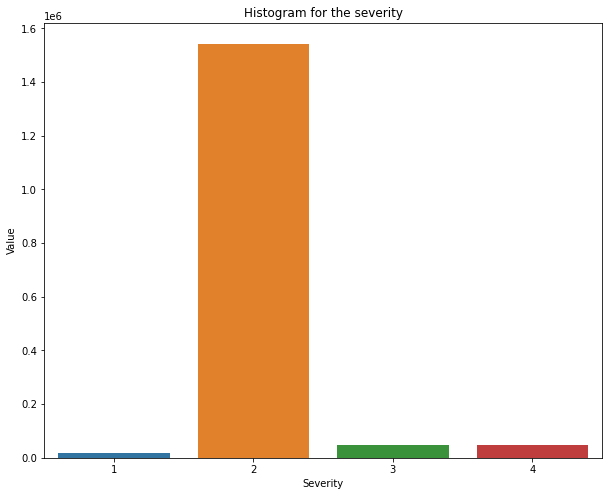

In [65]:
# imbalanced data set
import matplotlib.pyplot 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

severity_counts = y_train.value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

### Oversampling
###### In this section, compared two oversampling algorithms to determine which algorithm results in the best performance.And oversampled the data using the naive random oversampling algorithm and the SMOTE algorithm. 


#### Naive Random Oversampling

In [66]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
#X_resampled,y_resampled =ros.fit_resample(X_train_scaled,y_train)
X_resampled,y_resampled =ros.fit_resample(X_train,y_train)

In [67]:
# what is the "balance" or mix between Severity
Counter(y_resampled)

Counter({2: 1542885, 3: 1542885, 4: 1542885, 1: 1542885})

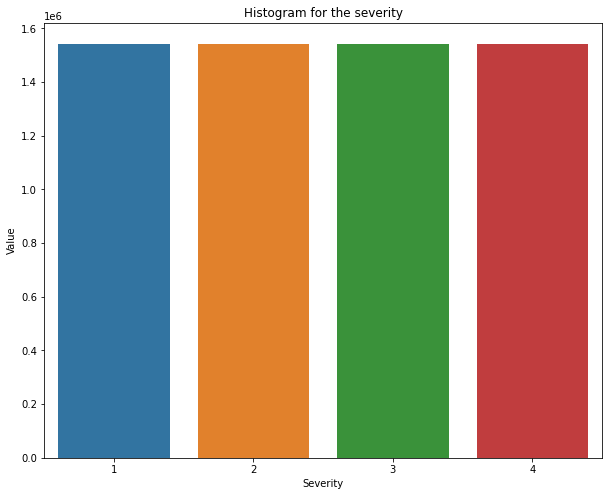

In [68]:
severity_counts = y_resampled.value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [69]:
# Train the Logistic Regression model using the resampled data
#model
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs',random_state=1)
#fit
clf.fit(X_resampled,y_resampled)
#predict using the predict method
y_pred = clf.predict(X_test)

In [70]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test,y_pred)

0.49117289697726485

In [71]:
# Display the confusion matrix
cm = confusion_matrix(y_test,y_pred,labels=clf.classes_)
cm

array([[  4007,    195,   1537,    188],
       [ 61435, 233045,  78203, 141507],
       [  6639,    624,   7974,    967],
       [  3154,   2822,   4210,   5325]], dtype=int64)

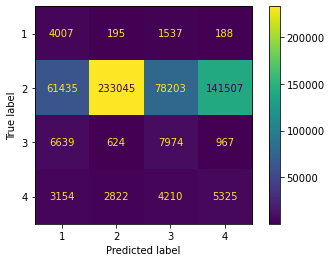

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= clf.classes_)
disp.plot()

In [73]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.05      0.68      0.87      0.10      0.77      0.58      5927
          2       0.98      0.45      0.90      0.62      0.64      0.39    514190
          3       0.09      0.49      0.84      0.15      0.64      0.40     16204
          4       0.04      0.34      0.73      0.07      0.50      0.24     15511

avg / total       0.92      0.45      0.90      0.59      0.64      0.39    551832



#### Ensemble Learners
###### In this section,  compared two ensemble algorithms to determine which algorithm results in the best performance. trained a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier .

#### Balanced Random Forest Classifier

In [74]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import EasyEnsembleClassifier

In [75]:
# Resample the training data with the BalancedRandomForestClassifier

#model
brf_model = BalancedRandomForestClassifier(random_state=1, n_estimators=100)
#fit
#brf_model = brf_model.fit(X_train_scaled, y_train)

brf_model = brf_model.fit(X_train, y_train)
#predict
predictions = brf_model.predict(X_test)

In [76]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test,predictions)


0.8252815534553988

In [77]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1","Actual 2", "Actual 3"], columns=["Predicted 0", "Predicted 1","Predicted 2", "Predicted 3"])

cm_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,5561,5,320,41
Actual 1,8832,426212,22725,56421
Actual 2,1114,222,13339,1529
Actual 3,366,1977,2143,11025


In [78]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.35      0.94      0.98      0.51      0.96      0.92      5927
          2       0.99      0.83      0.94      0.90      0.88      0.77    514190
          3       0.35      0.82      0.95      0.49      0.89      0.77     16204
          4       0.16      0.71      0.89      0.26      0.80      0.62     15511

avg / total       0.95      0.83      0.94      0.87      0.88      0.77    551832



In [79]:
# We can sort the features by their importance.
sorted (zip(brf_model.feature_importances_,X.columns),reverse=True)

[(0.1279929456566855, 'time_duration'),
 (0.11874526194795657, 'Distance(mi)'),
 (0.1004983178327134, 'Year'),
 (0.08563525246116671, 'Start_Lat'),
 (0.08400491901163397, 'Start_Lng'),
 (0.04550501691945835, 'State'),
 (0.04301363523702704, 'Pressure(in)'),
 (0.033555750135654185, 'County'),
 (0.03217311422645591, 'City'),
 (0.031605875589450466, 'Month'),
 (0.03114642966839414, 'Humidity(%)'),
 (0.02931593289167842, 'Wind_Chill(F)'),
 (0.028701569021468004, 'Temperature(F)'),
 (0.027001619749673376, 'Hour'),
 (0.024850378924006912, 'Day'),
 (0.022046819985442032, 'Timezone'),
 (0.02078915232868848, 'Wind_Speed(mph)'),
 (0.019807768908886546, 'Wind_Direction'),
 (0.01626456223800721, 'Weekday'),
 (0.014229143544517452, 'Weather_Condition'),
 (0.013393783136191688, 'Crossing'),
 (0.013346647034630383, 'Traffic_Signal'),
 (0.008681182985680493, 'Side'),
 (0.007916683612043033, 'Visibility(mi)'),
 (0.00599333999250975, 'Sunrise_Sunset'),
 (0.004984470468121937, 'Junction'),
 (0.0049002975

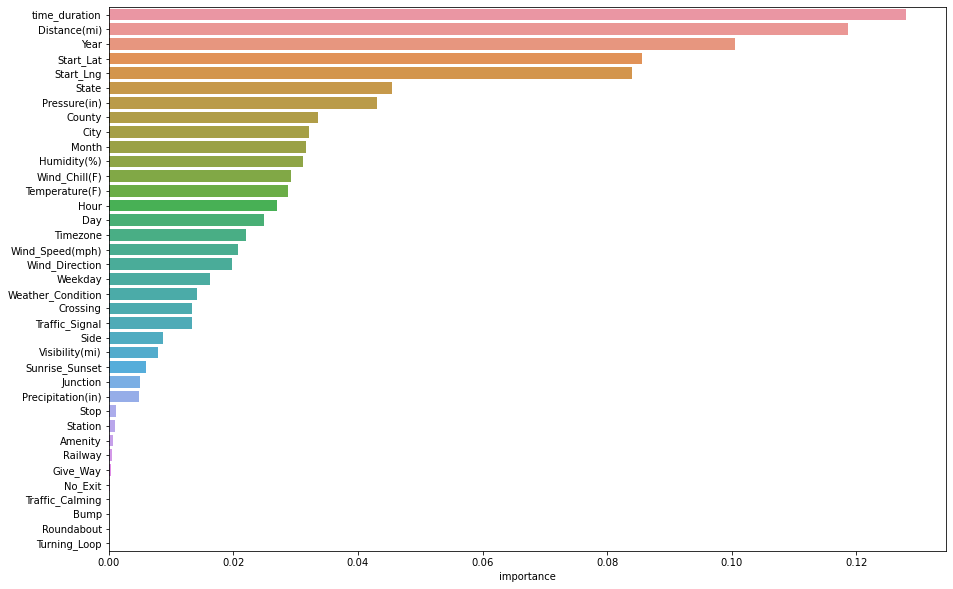

In [80]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = brf_model.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:40]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()